In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
import os
import seaborn as sns


In [2]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

import os
zad1_dir = "zad1"
os.makedirs(zad1_dir, exist_ok=True)
zad2_dir = "zad2"
os.makedirs(zad2_dir, exist_ok=True)

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

In [3]:
data = np.loadtxt('CH06PR15.txt')
X1 = data[:, 0] # Wiek
X2 = data[:, 1] # Ciężkość choroby
X3 = data[:, 2] # Poziom niepokoju
Y = data[:, 3]  # Satysfakcja

n = len(Y)
X = np.column_stack((np.ones(n), X1, X2, X3))
feature_names = ['Intercept', 'Wiek', 'Ciężkość', 'Niepokój']

print(f"Liczba obserwacji: {n}")
print(data[:5, :])

Liczba obserwacji: 46
[[48.  50.  51.   2.3]
 [57.  36.  46.   2.3]
 [66.  40.  48.   2.2]
 [70.  41.  44.   1.8]
 [89.  28.  43.   1.8]]


# 1

In [ ]:
# a)
# Theoretical
# Beta = (X^T X)^-1 X^T Y
Xt = X.T
XtX = Xt @ X
XtX_inv = np.linalg.inv(XtX)
XtY = Xt @ Y
beta_teor = XtX_inv @ XtY

print("Równanie regresji:")
print(f"Y = {beta_teor[0]:.4f} + {beta_teor[1]:.4f}*Wiek + {beta_teor[2]:.4f}*Ciężkość + {beta_teor[3]:.4f}*Niepokój")

# Built-in
model = sm.OLS(Y, X).fit()
beta_lib = model.params

table_a_data = []
for i, name in enumerate(feature_names):
    table_a_data.append([name, f"{beta_teor[i]:.6f}", f"{beta_lib[i]:.6f}"])

df_a = pd.DataFrame(table_a_data, columns=["Parametr", "Teoretycznie", "Biblioteka"])

print("\nPorównanie estymatorów (toer vs lib):")
print(df_a)

with open(os.path.join(zad1_dir, 'table_a_estimators.md'), 'w') as f:
    f.write(df_a.to_markdown(index=False))

Równanie regresji:
Y = 1.0532 + -0.0059*Wiek + 0.0019*Ciężkość + 0.0301*Niepokój

Porównanie estymatorów (toer vs lib):
    Parametr Teoretycznie Biblioteka
0  Intercept     1.053245   1.053245
1       Wiek    -0.005861  -0.005861
2   Ciężkość     0.001928   0.001928
3   Niepokój     0.030148   0.030148


In [6]:
# b)

# H0: beta1 = beta2 = beta3 = 0
# H1: istnieje i : beta_i != 0

# Theoretical
Y_mean = np.mean(Y)
Y_pred_teor = X @ beta_teor

SST = np.sum((Y - Y_mean)**2)
SSM = np.sum((Y_pred_teor - Y_mean)**2)
SSE = np.sum((Y - Y_pred_teor)**2)

R2_teor = SSM / SST

# Test F
p = 3
df_M = p
df_E = n - p - 1
MSR = SSM / df_M
MSE = SSE / df_E
F_stat_teor = MSR / MSE
p_val_F_teor = stats.f.sf(F_stat_teor, df_M, df_E)

print(f"Teoretyczne R^2: {R2_teor:.6f}")
print(f"Teoretyczna statystyka F: {F_stat_teor:.6f}")
print(f"Teoretyczna p-wartość (F): {p_val_F_teor:.6e}")

# Built-in
R2_lib = model.rsquared
F_stat_lib = model.fvalue
p_val_F_lib = model.f_pvalue

print(f"Biblioteczne R^2: {R2_lib:.6f}")
print(f"Biblioteczna statystyka F: {F_stat_lib:.6f}")
print(f"Biblioteczna p-wartość (F): {p_val_F_lib:.6e}")

# Tabela b
table_b_data = [
    ["R^2", f"{R2_teor:.6f}", f"{R2_lib:.6f}"],
    ["Statystyka F", f"{F_stat_teor:.6f}", f"{F_stat_lib:.6f}"],
    ["p-wartość F", f"{p_val_F_teor:.6e}", f"{p_val_F_lib:.6e}"]
]
df_b = pd.DataFrame(table_b_data, columns=["Metryka", "Teoretycznie", "Biblioteka"])
with open(os.path.join(zad1_dir, 'table_b_model_test.md'), 'w') as f:
    f.write(df_b.to_markdown(index=False))

alpha = 0.05
print("\nTest F:")
if p_val_F_lib < alpha:
    print(f"p-wartość ({p_val_F_lib:.4e}) < {alpha}, odrzucamy H0.")
    print("Istnieje istotna statystycznie zależność liniowa między zmiennymi objaśniającymi a satysfakcją.")
else:
    print(f"Brak podstaw do odrzucenia H0 (p = {p_val_F_lib:.4e}).")
    print("Nie istnieje istotna statystycznie zależność liniowa między zmiennymi objaśniającymi a satysfakcją.")

Teoretyczne R^2: 0.541548
Teoretyczna statystyka F: 16.537562
Teoretyczna p-wartość (F): 3.043110e-07
Biblioteczne R^2: 0.541548
Biblioteczna statystyka F: 16.537562
Biblioteczna p-wartość (F): 3.043110e-07

Test F:
p-wartość (3.0431e-07) < 0.05, odrzucamy H0.
Istnieje istotna statystycznie zależność liniowa między zmiennymi objaśniającymi a satysfakcją.


In [8]:
# c)
# H0: beta_i = 0
# H1: beta_i != 0

# Theoretical
Var_beta_matrix = MSE * XtX_inv
SE_beta_teor = np.sqrt(np.diag(Var_beta_matrix))
t_crit = stats.t.ppf(1 - alpha/2, df_E)

# artificial entries for intercept for easier indexing
CI_teor = [0]
t_stats_teor = [0]
p_vals_t_teor = [0]

# skip intercept
for i in range(1, 4):
    se = SE_beta_teor[i]
    beta = beta_teor[i]
    ci_lower = beta - t_crit * se
    ci_upper = beta + t_crit * se
    CI_teor.append((ci_lower, ci_upper))
    
    t_stat = beta / se
    t_stats_teor.append(t_stat)
    p_val = 2 * stats.t.sf(np.abs(t_stat), df_E)
    p_vals_t_teor.append(p_val)

# Built-in
CI_lib = model.conf_int(alpha=alpha)
t_stats_lib = model.tvalues
p_vals_t_lib = model.pvalues

# skip intercept
table_c_data = []
for i, name in enumerate(feature_names[1:4], start=1):    
    table_c_data.append([
        name, 
        f"({CI_teor[i][0]:.4f}, {CI_teor[i][1]:.4f})", 
        f"[{CI_lib[i][0]:.4f}, {CI_lib[i][1]:.4f}]",
        f"{t_stats_teor[i]:.4f}",
        f"{t_stats_lib[i]:.4f}",
        f"{p_vals_t_teor[i]:.4e}",
        f"{p_vals_t_lib[i]:.4e}"
    ])

df_c = pd.DataFrame(table_c_data, columns=["Zmienna", "CI (Teor)", "CI (Bibl)", "t-stat (Teor)", "t-stat (Bibl)", "p-val (Teor)", "p-val (Bibl)"])
print(df_c)
with open(os.path.join(zad1_dir, 'table_c_coeffs.md'), 'w') as f:
    f.write(df_c.to_markdown(index=False))

print("\nDecyzje dla współczynników:")
for i in range(1, 4):
    name = feature_names[i]
    p_val = p_vals_t_lib[i]
    ci = CI_lib[i]
    print(f"- {name}: p-wartość = {p_val:.4e}. ", end="")
    if p_val < alpha:
        print("Odrzucamy H0. Zmienna jest istotna statystycznie.")
    else:
        print("Brak podstaw do odrzucenia H0. Zmienna nie jest istotna statystycznie.")
    
    # Związek z przedziałami ufności
    contains_zero = ci[0] <= 0 <= ci[1]
    print(f"  Przedział ufności [{ci[0]:.4f}, {ci[1]:.4f}] {"zawiera" if contains_zero else "nie zawiera"} zera.")



    Zmienna          CI (Teor)          CI (Bibl) t-stat (Teor) t-stat (Bibl)  \
0      Wiek  (-0.0121, 0.0004)  [-0.0121, 0.0004]       -1.8973       -1.8973   
1  Ciężkość  (-0.0097, 0.0136)  [-0.0097, 0.0136]        0.3332        0.3332   
2  Niepokój   (0.0115, 0.0488)   [0.0115, 0.0488]        3.2569        3.2569   

  p-val (Teor) p-val (Bibl)  
0   6.4678e-02   6.4678e-02  
1   7.4065e-01   7.4065e-01  
2   2.2323e-03   2.2323e-03  

Decyzje dla współczynników:
- Wiek: p-wartość = 6.4678e-02. Brak podstaw do odrzucenia H0. Zmienna nie jest istotna statystycznie.
  Przedział ufności [-0.0121, 0.0004] zawiera zera.
- Ciężkość: p-wartość = 7.4065e-01. Brak podstaw do odrzucenia H0. Zmienna nie jest istotna statystycznie.
  Przedział ufności [-0.0097, 0.0136] zawiera zera.
- Niepokój: p-wartość = 2.2323e-03. Odrzucamy H0. Zmienna jest istotna statystycznie.
  Przedział ufności [0.0115, 0.0488] nie zawiera zera.


Test Shapiro-Wilka: Statystyka = 0.962864, p-wartość = 1.481172e-01
Brak podstaw do odrzucenia H0 o normalności rozkładu reszt.


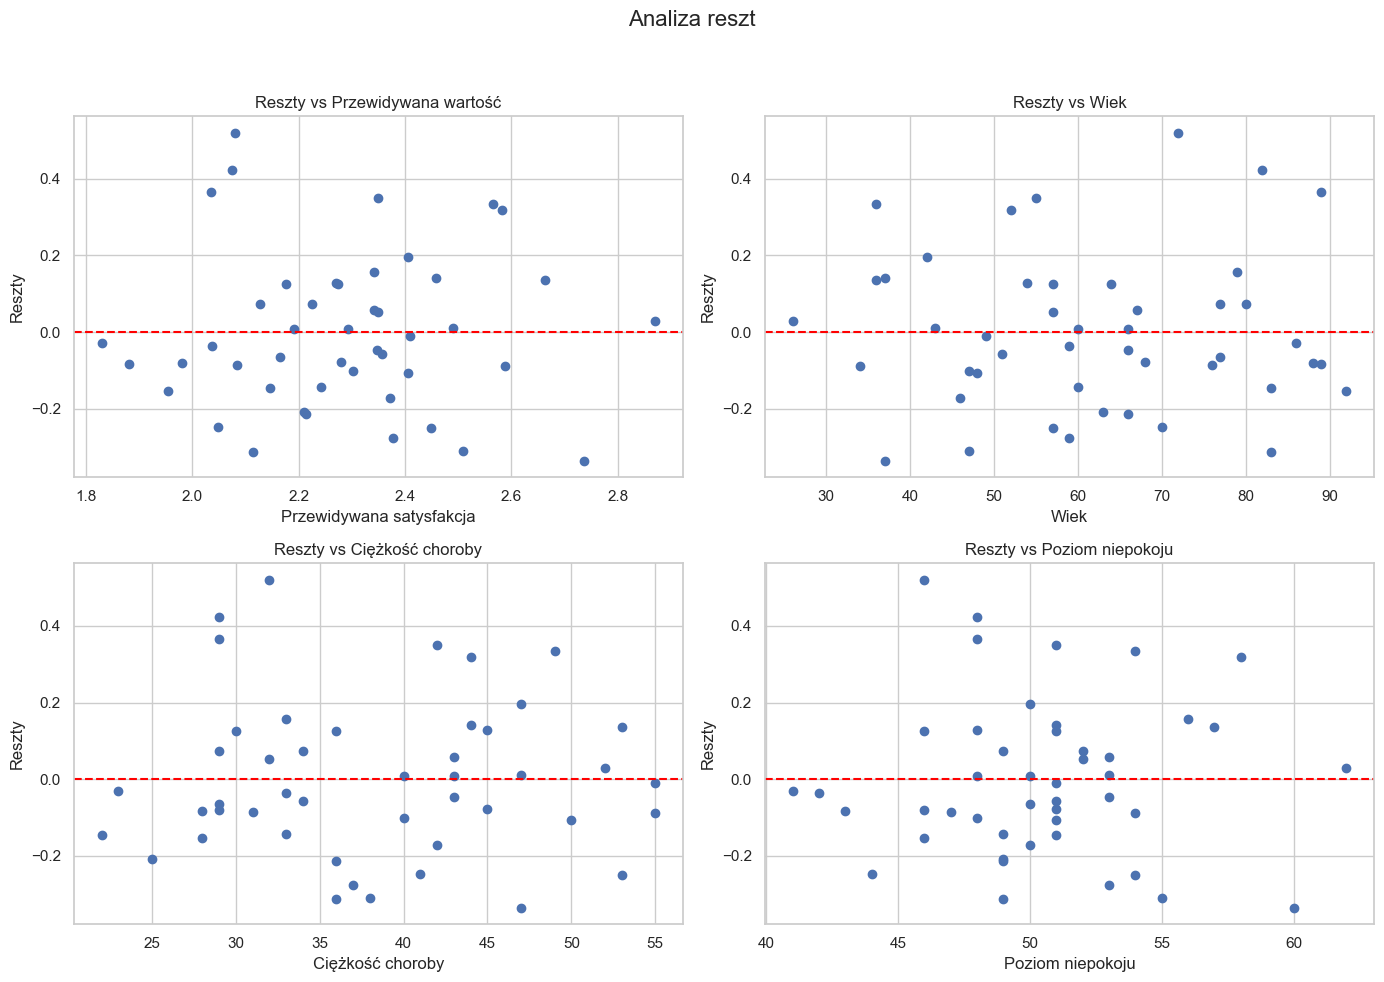

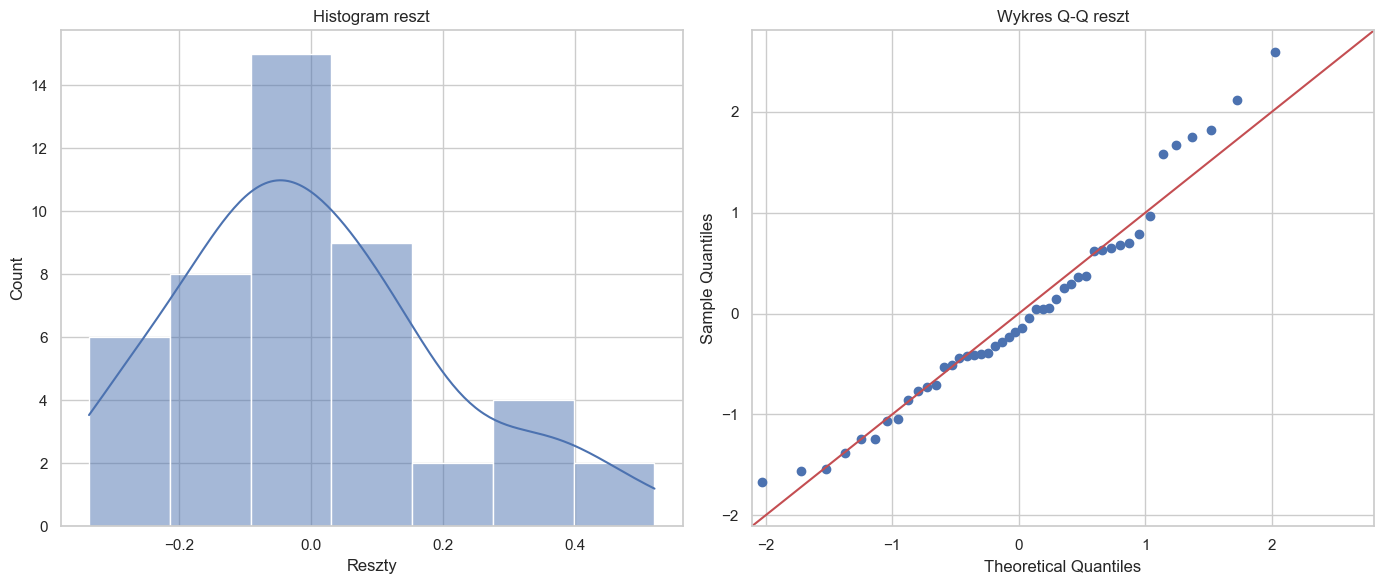

In [15]:
# d)
residuals = Y - Y_pred_teor

# Wykresy reszt vs zmienne
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Analiza reszt', fontsize=16)

# Reszty vs Y_pred
axes[0, 0].scatter(Y_pred_teor, residuals)
axes[0, 0].axhline(0, color='red', linestyle='--')
axes[0, 0].set_xlabel('Przewidywana satysfakcja')
axes[0, 0].set_ylabel('Reszty')
axes[0, 0].set_title('Reszty vs Przewidywana wartość')

# Reszty vs X1 (Wiek)
axes[0, 1].scatter(X1, residuals)
axes[0, 1].axhline(0, color='red', linestyle='--')
axes[0, 1].set_xlabel('Wiek')
axes[0, 1].set_ylabel('Reszty')
axes[0, 1].set_title('Reszty vs Wiek')

# Reszty vs X2 (Ciężkość)
axes[1, 0].scatter(X2, residuals)
axes[1, 0].axhline(0, color='red', linestyle='--')
axes[1, 0].set_xlabel('Ciężkość choroby')
axes[1, 0].set_ylabel('Reszty')
axes[1, 0].set_title('Reszty vs Ciężkość choroby')

# Reszty vs X3 (Niepokój)
axes[1, 1].scatter(X3, residuals)
axes[1, 1].axhline(0, color='red', linestyle='--')
axes[1, 1].set_xlabel('Poziom niepokoju')
axes[1, 1].set_ylabel('Reszty')
axes[1, 1].set_title('Reszty vs Poziom niepokoju')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(os.path.join(zad1_dir, 'plot_residuals_scatter.png'))

# Histogram i QQ-plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Histogram
sns.histplot(residuals, kde=True, ax=axes[0])
axes[0].set_title('Histogram reszt')
axes[0].set_xlabel('Reszty')

# QQ-plot
sm.qqplot(residuals, line='45', fit=True, ax=axes[1])
axes[1].set_title('Wykres Q-Q reszt')

plt.tight_layout()
plt.savefig(os.path.join(zad1_dir, 'plot_residuals_dist.png'))

# Test Shapiro-Wilka
shapiro_stat, shapiro_p = stats.shapiro(residuals)
print(f"Test Shapiro-Wilka: Statystyka = {shapiro_stat:.6f}, p-wartość = {shapiro_p:.6e}")
if shapiro_p > alpha:
    print("Brak podstaw do odrzucenia H0 o normalności rozkładu reszt.")
else:
    print("Odrzucamy H0. Reszty nie mają rozkładu normalnego.")

In [18]:
# e) 
# H0: beta1 = beta2 = 0 (Model zredukowany jest wystarczający - zmienne Wiek i Ciężkość są zbędne)
# H1: beta1 != 0 lub beta2 != 0 (Model pełny jest lepszy)

X_reduced = np.column_stack((np.ones(n), X3))
model_reduced = sm.OLS(Y, X_reduced).fit()
SSE_reduced = model_reduced.ssr
df_reduced = model_reduced.df_resid # n - 2

SSE_full = SSE
df_full = df_E # n - 4

# Theoretical
# F = ((SSE_R - SSE_F) / (df_R - df_F)) / (SSE_F / df_F)
numerator = (SSE_reduced - SSE_full) / (df_reduced - df_full)
denominator = SSE_full / df_full
F_general_teor = numerator / denominator
p_val_general_teor = stats.f.sf(F_general_teor, df_reduced - df_full, df_full)

print(f"SSE (Zredukowany - tylko Niepokój): {SSE_reduced:.6f}, df: {df_reduced}")
print(f"SSE (Pełny): {SSE_full:.6f}, df: {df_full}")
print(f"Teoretyczna statystyka F (ogólna): {F_general_teor:.6f}")
print(f"Teoretyczna p-wartość: {p_val_general_teor:.6e}")

# Built-in
anova_results = sm.stats.anova_lm(model_reduced, model)
print("\nWyniki ANOVA (Bibl):")
print(anova_results)

F_general_lib = anova_results['F'].iloc[1]
p_val_general_lib = anova_results['Pr(>F)'].iloc[1]

table_e_data = [
    ["Statystyka F", f"{F_general_teor:.6f}", f"{F_general_lib:.6f}"],
    ["p-wartość", f"{p_val_general_teor:.6e}", f"{p_val_general_lib:.6e}"]
]
df_e = pd.DataFrame(table_e_data, columns=["Metryka", "Teoretycznie", "Biblioteka"])
with open(os.path.join(zad1_dir, 'table_e_general_f.md'), 'w') as f:
    f.write(df_e.to_markdown(index=False))

print("\nKonkluzja (porównanie modeli):")
if p_val_general_lib < alpha:
    print(f"p-wartość ({p_val_general_lib:.4e}) < {alpha}. Odrzucamy H0.")
    print("Model pełny (3 zmienne) jest istotnie lepszy niż model z jedną zmienną (Niepokój).")
else:
    print(f"p-wartość ({p_val_general_lib:.4e}) >= {alpha}. Brak podstaw do odrzucenia H0.")
    print("Dodanie zmiennych (Wiek, Ciężkość) nie poprawia istotnie modelu opartego na Niepokoju.")



SSE (Zredukowany - tylko Niepokój): 2.219274, df: 44.0
SSE (Pełny): 1.848557, df: 42
Teoretyczna statystyka F (ogólna): 4.211414
Teoretyczna p-wartość: 2.153099e-02

Wyniki ANOVA (Bibl):
   df_resid       ssr  df_diff   ss_diff         F    Pr(>F)
0      44.0  2.219274      0.0       NaN       NaN       NaN
1      42.0  1.848557      2.0  0.370716  4.211414  0.021531

Konkluzja (porównanie modeli):
p-wartość (2.1531e-02) < 0.05. Odrzucamy H0.
Model pełny (3 zmienne) jest istotnie lepszy niż model z jedną zmienną (Niepokój).
